In [1]:
import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp

In [2]:
## Get all the data

## Get Law Dome

Law_Dome = pd.read_csv('./Conc_fit_data/law2006.txt',index_col=0,skiprows=183,nrows=2188-184,delim_whitespace=True,usecols=[0,3,5,8],names=['Year','CH4','CO2','N2O'])

# Get NOAA atmospheric observations

obsv_concs = pd.read_csv('./Conc_fit_data/NOAA_Conc_data.csv',skiprows=4,header=None,index_col=0).dropna().iloc[:,:3].values
obsv_concs = pd.DataFrame(data=obsv_concs,index = np.arange(1979,2018),columns=['CO2','CH4','N2O'])

N2O_ems_1890_1990 = pd.read_csv('./Conc_fit_data/edgar_hyde1.4-glob_n2o.csv',index_col=0)
N2O_ems_1970_2012 = pd.read_csv('./Conc_fit_data/v432_N2O_1970_2012.csv',index_col=0)

CH4_ems_1850_2014 = pd.read_csv('./Conc_fit_data/CEDS_CH4_global_emissions_1850_2014.csv',index_col=0,names=['Year','CH4'])
CO2_ems_1750_2014 = pd.read_csv('./Conc_fit_data/CEDS_CO2_global_emissions_1750_2014.csv',index_col=0,names=['Year','CO2'])*(12/44)

RCP3PD_E = pd.read_csv('./RCP_data/RCP3PD_EMISSIONS.csv',skiprows=36,index_col=0)
RCP_ems = pd.DataFrame(data = np.array([RCP3PD_E[['OtherCO2','FossilCO2']].sum(axis=1).values,RCP3PD_E['CH4'].values,RCP3PD_E['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = RCP3PD_E.index)

## Now we need to harmonise the datasets to get a full 1765 - 2015 run

N2O_ems_1890_1970_vals = (N2O_ems_1890_1990.loc[range(1890,1970)] + N2O_ems_1970_2012.loc[1970] - N2O_ems_1890_1990.loc[1970]).values.flatten()
N2O_ems_1765_1890_vals = (RCP_ems.N2O.loc[range(1765,1890)] * N2O_ems_1890_1970_vals[0] / RCP_ems.N2O.loc[1890]).values
N2O_ems_1970_2012_vals = N2O_ems_1970_2012.values.flatten()

N2O_ems_1765_2012 = pd.DataFrame(np.concatenate((N2O_ems_1765_1890_vals,N2O_ems_1890_1970_vals,N2O_ems_1970_2012_vals)),columns=['N2O'],index = np.arange(1765,2013))
N2O_ems_1765_2012 = N2O_ems_1765_2012.interpolate(method='linear',axis=0)


CH4_ems_1850_2014_vals = CH4_ems_1850_2014.drop_duplicates().values.flatten()
CH4_ems_1765_1850_vals = (RCP_ems.CH4.loc[range(1765,1850)] * CH4_ems_1850_2014_vals[0] / RCP_ems.CH4.loc[1850]).values.flatten()

CH4_ems_1765_2014 = pd.DataFrame(np.concatenate((CH4_ems_1765_1850_vals,CH4_ems_1850_2014_vals)),columns=['CH4'],index = np.arange(1765,2015))

CO2_ems_1765_2014 = CO2_ems_1750_2014.loc[1765:] ## Not including OtherCO2 for now? CEDS seems to be fossil co2

/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [172]:
## Get a temp response:

forcings = pd.read_csv('./Conc_fit_data/Annualforcings_Mar2014_GHGrevised.txt',skiprows=3,sep='\t',index_col=0)
empty_ems = pd.DataFrame(index=forcings.index,columns=['CO2','CH4','N2O']).fillna(0.)
T_ant = UnFaIR(emissions_in=empty_ems,F_ext=forcings.Anthrototal.values)['T']
T_nat = UnFaIR(emissions_in=empty_ems,F_ext=(forcings.Total.values - forcings.Anthrototal.values))['T']

T_response = (T_ant*0.912621338044 + T_nat*0.395722694204).loc[range(1765,2015)]

In [203]:
emissions = (CO2_ems_1765_2014+pd.DataFrame(data=RCP3PD_E.OtherCO2.loc[:2014].values,columns=['CO2'],index=CO2_ems_1765_2014.index)).copy()
emissions['CH4'] = CH4_ems_1765_2014
emissions['N2O'] = N2O_ems_1765_2012
emissions['N2O'].loc[2013] = 2*emissions['N2O'].loc[2012] - emissions['N2O'].loc[2011]
emissions['N2O'].loc[2014] = 2*emissions['N2O'].loc[2013] - emissions['N2O'].loc[2012]

params = default_gas_params().copy()
params.loc['PI_conc'].CH4 = 700

emissions['N2O'] = emissions['N2O']*6.6 / emissions.N2O.loc[2010]

#CO2_fit = sp.optimize.minimize(fit_gas_cycles,np.array([0,0,0]),args=(emissions,obsv_concs,T_response,'CO2'),method='Powell')
#CH4_fit = sp.optimize.minimize(fit_gas_cycles,np.array([0,0,0,9]),args=(emissions,obsv_concs,T_response+0.1,'CH4',params),method='Powell')
#N2O_fit = sp.optimize.minimize(fit_gas_cycles,np.array([0,0,0]),args=(emissions,obsv_concs,T_response,'N2O'),method='Powell')

In [222]:
## Get an "other" forcing dataset:
RCP85_forc = pd.read_csv('./Conc_fit_data/RCP85_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

otherforc = RCP85_forc.TOTAL_INCLVOLCANIC_RF.loc[:2014].values - RCP85_forc.CO2CH4N2O_RF.loc[:2014].values

                      CO2         CH4         N2O
a1               0.217300    1.000000    1.000000
a2               0.224000    0.000000    0.000000
a3               0.282400    0.000000    0.000000
a4               0.276300    0.000000    0.000000
tau1       1000000.000000    9.150000  116.000000
tau2           394.400000    1.000000    1.000000
tau3            36.540000    1.000000    1.000000
tau4             4.304000    1.000000    1.000000
r0              37.493303    8.540000   67.231092
rC               0.001900    0.000000    0.000000
rT               3.616153   -0.360000    0.000000
rA               0.000000    0.000310   -0.000906
PI_conc        278.000000  700.000000  273.000000
emis2conc        0.468952    0.351714    0.200980


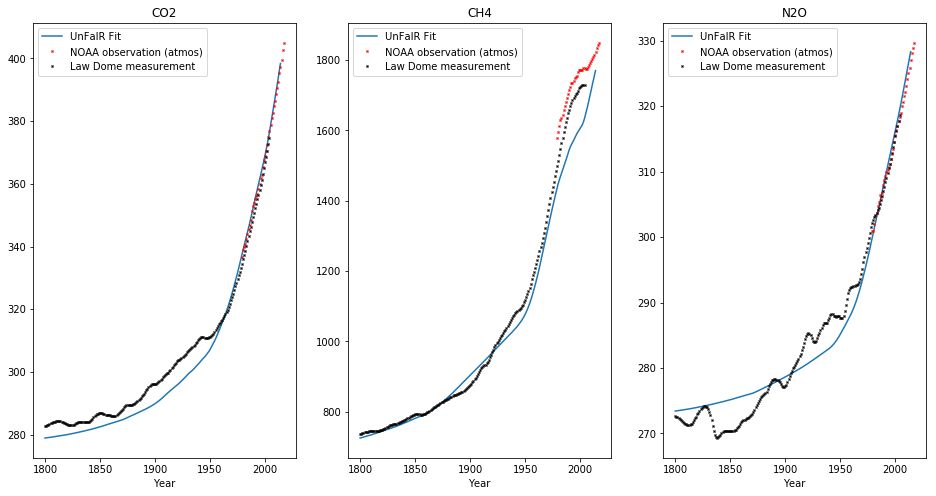

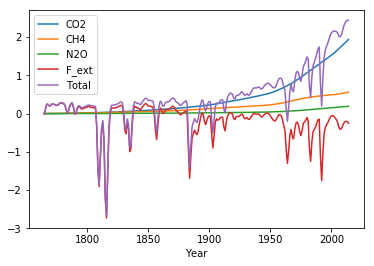

In [232]:
 # Try with Prather CH4 values
params.loc['r0'] = np.array([CO2_fit['x'][0],8.54,67.23109226573325]) # CH4 Prather : 8.53773764 (8.65) # N2O 67.23109226573325
params.loc['rC'] = np.array([0.0019,0,0])
params.loc['rT'] = np.array([CO2_fit['x'][2],-3.6e-01,0]) # CH4 Prather : -3.60100511e-01 (-4.3e-01)
params.loc['rA'] = np.array([0,3.1e-04,-0.00090625]) # CH4 Prather : 3.09667588e-04 (3.17e-04) # N2O -0.00090625
params.loc['tau1']['CH4'] = 9.15

print(params)

result = UnFaIR(emissions_in=emissions,F_ext=otherforc,gas_params=params)

fig,ax=plt.subplots(1,3,figsize=(16,8))
for i,s in enumerate(['CO2','CH4','N2O']):
    result['C'][s].loc[1800:].plot(ax=ax[i],label='UnFaIR Fit')
    obsv_concs[s].plot(ax=ax[i],marker='x',linewidth=0,ms=2,color='r',label='NOAA observation (atmos)')
    Law_Dome[s].loc[1800:].plot(ax=ax[i],marker='x',linewidth=0,ms=2,color='k', label='Law Dome measurement')
    ax[i].set_title(s)
    ax[i].legend()
    
fig1,ax1=plt.subplots()
result['RF'].plot(ax=ax1)

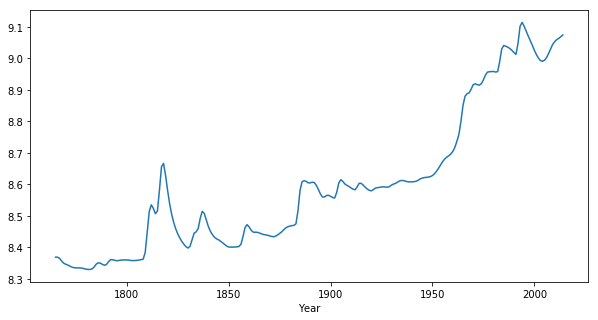

In [233]:
fig,ax=plt.subplots(figsize=(10,5))
(result['alpha'].CH4*params.loc['tau1']['CH4']).plot()

#(result['T']).plot(ax=ax,color='b')
#(T_response+0.1).plot(ax=ax,color='g')

In [223]:
## Running RCP8.5 through...
RCP85_E = pd.read_csv('./RCP_data/RCP85_EMISSIONS.csv',skiprows=36,index_col=0)
RCP85_ems = pd.DataFrame(data = np.array([RCP85_E[['OtherCO2','FossilCO2']].sum(axis=1).values,RCP85_E['CH4'].values,RCP85_E['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = RCP85_E.index)

future_emissions = emissions.append(RCP85_ems.loc[2015:] - RCP85_ems.loc[2014] + emissions.loc[2014])

RCP85_results = UnFaIR(emissions_in=future_emissions,F_ext=RCP85_forc.TOTAL_INCLVOLCANIC_RF.values - RCP85_forc.CO2CH4N2O_RF.values,gas_params=params)

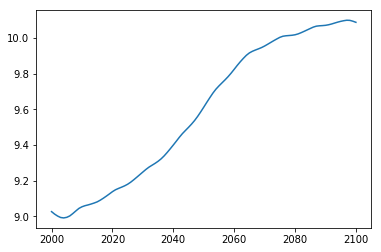

In [235]:
(RCP85_results['alpha'].CH4.loc[2000:2100]*9.15).plot()